#Модуль 3. Мультимодальные и мультизадачные модели. Часть 1.
##Семинар №5. Техники Fusion
##Цель занятия:
Рассмотреть задачу, где с помощью fusion модальностей можно улучшить качество модели

##Подготовительный этап:

Загружаем данные для семинара. Вам нужно получить kaggle API ключ для того, чтобы загрузить данные.

Гайд по созданию API ключ: https://www.kaggle.com/docs/api

In [ ]:
import os
import json


with open('kaggle.json', 'r') as f:
  data = json.load(f)
  os.environ['KAGGLE_USERNAME'] = data["username"]
  os.environ['KAGGLE_KEY'] = data["key"]

In [ ]:
!pip install pydicom

In [ ]:
!kaggle competitions download -c rsna-miccai-brain-tumor-radiogenomic-classification

100% 12.3G/12.3G [01:58<00:00, 31.2MB/s]
100% 12.3G/12.3G [01:58<00:00, 111MB/s] 


In [ ]:
!unzip -l /content/rsna-miccai-brain-tumor-radiogenomic-classification.zip

In [ ]:
!unzip -p /content/rsna-miccai-brain-tumor-radiogenomic-classification.zip train_labels.csv > train_labels.csv

In [ ]:
import zipfile
with zipfile.ZipFile("/content/rsna-miccai-brain-tumor-radiogenomic-classification.zip","r") as zip_ref:
    list_of_files = zip_ref.namelist()

In [ ]:
import zipfile
with zipfile.ZipFile("/content/rsna-miccai-brain-tumor-radiogenomic-classification.zip","r") as zip_ref:
    for n in range(101):
        x = f'train/{n:05}'
        res = list(filter(lambda y: y.startswith(x), list_of_files))
        for elem in res:
            zip_ref.extract(elem, 'folder')

Данные готовы!

# Мультимодальные модели глубокого обучения



#### Подобно врачам-людям, автоматизированные системы обнаружения и классификации, которые используют как данные медицинской визуализации, так и клинические данные из ЭМК, такие как демографические данные пациентов, предыдущие диагнозы и лабораторные данные, вероятно, создадут модели с более высокой производительностью. Недавняя литература по медицинской визуализации также демонстрирует аналогичную тенденцию, когда как EHR, так и пиксельные данные используются в «парадигме слияния» для решения сложных задач, которые невозможно легко решить с помощью одного лишь метода (Huang et al. 2020).

####Современная медицина опирается на синтез широкого спектра информации, такой как данные визуализации, лабораторные данные, неструктурированные повествовательные данные, 1D-сигналы, такие как ЭКГ, а в некоторых случаях аудиоданные или данные наблюдений. Клинический контекст изображений часто играет решающую роль в принятии диагностических решений при интерпретации медицинских изображений. Например, неоднократно было показано, что отсутствие доступа к клиническим и лабораторным данным во время интерпретации изображений приводит к снижению производительности и снижению клинической полезности для направляющего специалиста. В опросе рентгенологов большинство (87%) заявили, что клиническая информация оказывает значительное влияние на интерпретацию (Boonn and Langlotz 2009). Радиология — не единственная медицинская специальность, основанная на визуализации, которая полагается на контекст для точной интерпретации данных визуализации; патология, офтальмология и дерматология также используют клинический контекст для интерпретации клинических изображений. Имея точную и актуальную информацию о текущих симптомах и истории болезни, врачи могут лучше интерпретировать результаты визуализации в соответствующем клиническом контексте, что приводит к более точному дифференциальному диагнозу, более полезному отчету для врачей и более благоприятному исходу для пациента.
####Модели сверточных нейронных сетей (CNN) обычно используют значения пикселей в качестве входных данных без контекстуализации другой клинической информации, как это делают врачи в клинической практике, что может ограничивать производительность. В качестве примера рассмотрим «простую» задачу в радиологии по выявлению пневмонии на рентгенограмме грудной клетки (CXR), которую удалось решить многим исследователям, обучающим модели глубокого обучения для автоматического обнаружения и классификации патологий. Однако такие приложения в конечном итоге могут иметь ограниченное влияние на клиническую практику без клинического контекста, такого как основная жалоба, история настоящего заболевания, история болезни в прошлом, история приема лекарств, семейный анамнез, результаты медицинского осмотра и лабораторные показатели. Несмотря на наличие результатов визуализации, которые могут отличить пневмонию от других диагнозов, рентгенограмма неспецифична, и для точного диагноза требуется клиническая и лабораторная информация. Результаты рентгенологической рентгенографии, предполагающие пневмонию, будут точными у пациентов с лихорадкой и повышенным количеством лейкоцитов, но у пациентов без подобных клинических особенностей или лабораторных показателей подобные изображения могут указывать на ателектаз, отек легких, интерстициальное заболевание или даже рак легких.

####Сначала мы обсудим различные методы слияния в глубоком и машинном обучении, затем обсудим некоторые медицинские примеры мультимодальности и, наконец, разработаем простую мультимодальную модель.

###Способы слияния

####Слияние изображений — это метод объединения информации из нескольких источников данных изображений, полученных с помощью одних и тех же или разных модальностей. Целью объединения изображений, особенно в медицинской визуализации, является улучшение или дополнение функций каждого источника данных, чтобы алгоритмы машинного обучения могли достичь более высокой производительности, а не использовать только один канал данных. Ожидаемый результат будет иметь более богатое представление функций, чем отдельные компоненты. Техника мультимодального слияния добилась замечательных успехов в различных приложениях, таких как сегментация медицинских изображений, классификация изображений и реконструкция изображений.
####Для объединения данных требуется более одного источника данных (например, это могут быть данные одного исследования, например Т1 и Т2 МРТ, или разных исследований, таких как МРТ и КТ). В традиционной литературе по обработке изображений они называются «каналами», и мы также будем использовать эту номенклатуру. Каналы данных могут быть разнородными, дополняющими друг друга, согласованными или несогласованными, синхронными или асинхронными, а также избыточными с разными масштабами, которые необходимо нормализовать для объединения. Медицинские изображения, такие как МРТ/КТ/ПЭТ/УЗИ, также имеют различия, которые необходимо учитывать при их совместном использовании. Поэтому выбор алгоритма или архитектуры зависит в первую очередь от цели приложения и характеристик канала передачи данных. Подводя итог, преимущества объединения данных (Bellot et al. 2002):
####1) Предоставить различную информацию, которая поможет повысить уверенность в диагнозе.
####2) Чтобы объединить исходные функции и извлечь новую или скрытую информацию с повышенной достоверностью.
####3) Повысить абстракцию и полноту данных за счет их эффективного объединения.
####В недавних публикациях по компьютерному зрению люди исследуют стратегии мультимодального слияния в контексте пространственно-временной сверточной нейронной сети (Karpathy et al. 2014) и в целом разделяют их на четыре модели/класса слияния: раннее слияние, позднее слияние, совместное слияние и медленное слияние.

###Раннее слияние:

####Раннее слияние объединяет различные каналы данных в начале обучения модели машинного обучения. Эти отдельные особенности модальности могут быть объединены различными способами, например, с помощью пулинга по среднему значению, взвешенной конкатенации или методов контролируемого слияния (тип I или II на рис. 1). Унимодальные локальные объекты первоначально извлекаются из отдельных входных данных, а затем объединяются в совместное представление. Следовательно, унифицированная модель должна гарантировать, что данные/функции правильно выровнены, чтобы обеспечить совместную обработку. В результате преобразование источников данных в единый вектор признаков является серьезной проблемой при использовании ранних подходов к слиянию данных. В действительности, условно независимые критерии между источниками медицинских данных не всегда верны, поскольку несколько модальностей могут иметь сильно коррелирующие характеристики, возможно, из-за условий сбора данных. Таким образом, различные способы сбора данных обычно пространственно выровнены (так называемая регистрация изображений) со стандартной частотой сэмлпирования пикселей (для изображений или, возможно, временем для других модальностей), чтобы создать общую основу для объединения. Если данные выровнены правильно, можно использовать взаимную корреляцию между элементами данных, что дает возможность повысить производительность системы (Gadzicki et al. 2020).

<img src="https://i.ibb.co/WchcPN1/fig1.png"><br>
*Figure 1.* **Early Fusion**<br><br>


###Позднее или ансамблевое слияние:

####При позднем слиянии отдельные потоки полностью обрабатывают каждый канал данных отдельно, а их выходные данные объединяются на этапе принятия решения или прогнозирования посредством суммирования, операции усреднения или голосования большинством. Подобно методу ансамбля, процесс позднего слияния обучается оптимальному комбинированию каждого компонента, которое максимизирует производительность. Процесс обучения обрабатывает ошибки независимо, декоррелирует ошибки и, таким образом, повышает производительность в отношении каждой модальности. Главный недостаток заключается в ограниченных возможностях использования взаимной корреляции между различными унимодальными данными.
<img src="https://i.ibb.co/T2JHW4X/fig2.png"><br>
*Рисунок 2.* **Поздний слияние** <br><br>
###Совместное слияние
####Совместное слияние было введено для объединения представлений функций визуализации с клиническими особенностями перед их подачей в модель. Из-за различий между визуализацией и клиническими особенностями в размерности и динамическом диапазоне были представлены разные модели (Haylat 2020) для масштабирования их клинических характеристик перед слиянием и улучшения их характеристик (рис. 3).
<img src="https://i.ibb.co/kKxVYfz/fig3.png"><br>
*Рисунок 3.* **Совместное слияние, тип I (вверху) и тип II (внизу)** <br><br>
###Медленный синтез
####Медленное слияние широко используется в 3D-видео, как пространственное, так и временное измерения (Хуанг и др., 2020) начинаются с нескольких сетей, которые принимают последовательные видеокадры и медленно объединяют их временные характеристики по всей сети, так что более высокие уровни постепенно получают доступ к глобальной информации (Karpathy et al. 2014). Как показано на рис. 4, вся архитектура разделена на четыре уровня действий, которые постепенно разделяют параметры обучения. На первом уровне каждая модель использует четыре временные последовательности, которые проходят через серию сверток, создавая четыре карты признаков. Второй уровень обрабатывает серию из двух временных признаков из четырех карт признаков и передает их на третий уровень, последовательно получая информацию по всем входным видеокадрам. Наконец, четвертый уровень выполняет операцию пулинга для глобального извлечения признаков и в конечном итоге соединяет более высокие задачи (классификацию) плотным соединением. Таким образом, модели машинного обучения или CNN извлекают выгоду из изучения мощных функций с последующими совмещенными связями и могут быть устойчивыми к деталям связности во времени.
<img src="https://i.ibb.co/St6Ccz9/fig4.png"><br>
*Рисунок 4.* **Медленное слияние.**



###Мультимодальное обучение с использованием только изображений:

####Как мы обсуждали ранее, мультимодальность может возникать из множества источников; здесь обсуждается обучение «изображение-изображение».

####Мультимодальные визуализирующие исследования обычно требуют совместной регистрации. Процесс совместной регистрации изображений включает геометрическое выравнивание двух или более изображений так, чтобы их соответствующие пиксели (вокселы) представляли один и тот же объект. В целом совместную регистрацию изображений можно разделить на две категории в зависимости от ссылки: при первом подходе изображения регистрируются в существующем атласе; другой подход регистрирует изображения в одно выбранное изображение. Очень важно, чтобы этот процесс был предпринят до любого последующего количественного анализа изображения. Для регистрации изображений доступны различные методы, включая регистрацию на основе DL и традиционную регистрацию, которые выходят за рамки этой главы (для дальнейшего чтения см. (Haskins, Kruger and Yan 2020)).
####Мультимодальная визуализация имеет множество реальных примеров, одним из которых является сочетание структурной и функциональной (молекулярной) визуализации, такой как ПЭТ-КТ и ПЭТ-МР. Поскольку молекулярная визуализация имеет ограниченное пространственное разрешение, она не может точно показать расположение опухолей, а индикаторы часто не захватываются достаточным количеством структур, чтобы прояснить анатомическое расположение. Получая изображения КТ или МРТ на одном физическом устройстве, можно определить точное анатомическое расположение (рис. 5).
<img src="https://i.ibb.co/vZf4V1b/fig5.png"><br>
*Рисунок 5.* **(a) Совместно зарегистрированная ПЭТ-КТ, (b) КТ, (c) ПЭТ**<br><br>
####Еще один пример — слияние КТ-МРТ для лучевой терапии. МРТ имеет превосходное разрешение мягких тканей и может выявить опухоль, которую трудно оценить на КТ. С другой стороны, МРТ не отражает ослабление радиации, что имеет решающее значение для точной доставки дозы. В результате объединение изображений МРТ с КТ широко используется в радиохирургии, интервенционной радиологии и лучевой терапии. (Лю и др., 2019) (рис. 6)
<img src="https://i.ibb.co/qjyf2Z6/fig6.png"><br>
*Рисунок 6.* **(а) КТ, (б) зарегистрированная КТ-МРТ, (в) МРТ **<br><br>
####Хотя в приведенных выше примерах мы использовали разные модальности, бывают случаи, когда плоскости или способы получения одной и той же модальности могут дать разные типы информации, которую можно использовать. Например, использование как медиолатеральной косой (MLO), так и краниокаудальной (CC) проекций маммограммы повышает точность диагностической визуализации для выявления рака молочной железы по сравнению с использованием только одной. (рис. 7)

#### Здесь мы собираемся обучить модель определению статуса метилирования промотора MGMT у пациентов с опухолью ГБМ.
##### Мы собираемся использовать T2, T1, постконтрастные изображения T1, последовательности МРТ FLAIR, а также маску опухоли.

### Загружаем библиотеки

In [ ]:
!pip install monai wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
import os

import math
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import monai as mn
import nibabel as nib

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import wandb

### Выбираем один GPU, если их много / Настраиваем среду WANDB

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['WANDB_API_KEY']= #Введите здесь ваш WAND API KEY.
os.environ['WANDB_SILENT']='true'

### Делаем процесс обучения детерминированным

In [ ]:
def seed_all(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    mn.utils.misc.set_determinism(seed=seed)


seed_all(123)

### Настраиваем некоторые гиперпараметры

In [ ]:
# Гиперпараметры
bs = 4
lr = 1e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 15

### Загружаем метки (статус метилирования MGMT) для каждого пациента

In [ ]:
df = pd.read_csv("/content/train_labels.csv")  # csv путь
df.head(3)

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0


In [ ]:
list_0 = os.listdir("/content/folder/train")

In [ ]:
def path_maker_list(patient_list: list, path: str):
    path_list = []
    for item in patient_list:
        path_patient = os.path.join(path, item)
        path_list.append(path_patient)
    return path_list

In [ ]:
path_list_0 = path_maker_list(
    list_0, "/content/folder/train"
)
len(path_list_0)

65

##### Создайте список словарей, которые для каждого пациента содержат пути к различным последовательностям МРТ и метки.

In [ ]:
df = df[:65]

### Разделение датасета для обучения и валидации на уровне пациентов

In [ ]:
df_train, df_val = train_test_split(
    df,
    test_size=0.19,
    train_size=0.81,
    random_state=123,
    shuffle=True,
    stratify=df["MGMT_value"],
)

In [ ]:
print("Number of positive train samples:", len(df_train[df_train["MGMT_value"] == 1]))
print("Number of negative train samples:", len(df_train[df_train["MGMT_value"] == 0]))
print("Number of positive validation samples:", len(df_val[df_val["MGMT_value"] == 1]))
print("Number of negative validation samples:", len(df_val[df_val["MGMT_value"] == 0]))
print(
    "Ratio of positive to negative samples in train set:",
    len(df_train[df_train["MGMT_value"] == 1])
    / len(df_train[df_train["MGMT_value"] == 0]),
)
print(
    "Ratio of positive to negative samples in validation set:",
    len(df_val[df_val["MGMT_value"] == 1]) / len(df_val[df_val["MGMT_value"] == 0]),
)

Number of positive train samples: 32
Number of negative train samples: 20
Number of positive validation samples: 8
Number of negative validation samples: 5
Ratio of positive to negative samples in train set: 1.6
Ratio of positive to negative samples in validation set: 1.6


Number of Total positive samples:40
Number of Total Negative samples:25


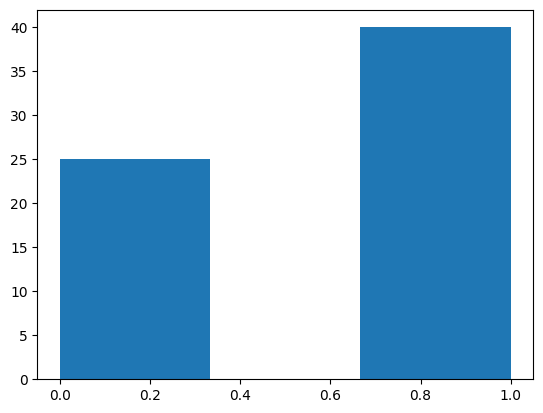

In [ ]:
df["MGMT_value"].hist(grid=False, bins=3)
len_neg = len(df[df["MGMT_value"] == 0])
len_pos = len(df[df["MGMT_value"] == 1])
print(
    f"Number of Total positive samples:{len_pos}\nNumber of Total Negative samples:{len_neg}"
)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import glob
import albumentations as A
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import roc_auc_score
from torch.optim import lr_scheduler
from tqdm import tqdm
import re

### Создаем датасет

In [ ]:
NUM_IMAGES_3D = 64
TRAINING_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
IMAGE_SIZE = 256
N_EPOCHS = 15
do_valid = True
n_workers = 4
type_ = "T1wCE"

In [ ]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    if rotate > 0:
        rot_choices = [
            0,
            cv2.ROTATE_90_CLOCKWISE,
            cv2.ROTATE_90_COUNTERCLOCKWISE,
            cv2.ROTATE_180,
        ]
        data = cv2.rotate(data, rot_choices[rotate])

    data = cv2.resize(data, (img_size, img_size))
    return data
import random

import cv2
from torch.utils.data import Dataset


class BrainRSNADataset(Dataset):
    def __init__(
        self, data, transform=None, target="MGMT_value", mri_type="FLAIR", is_train=True
    ):
        self.target = target
        self.data = data
        self.type = mri_type

        self.transform = transform
        self.is_train = is_train
        self.folder = "train" if self.is_train else "test"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        case_id = int(row.BraTS21ID)
        target = int(row[self.target])
        _3d_images = self.load_dicom_images_3d(case_id, self.type)
        _3d_images = torch.tensor(_3d_images).float()
        if self.is_train:
            return {"image": _3d_images, "target": target}

    def load_dicom_images_3d(
        self,
        case_id,
        type,
        num_imgs=NUM_IMAGES_3D,
        img_size=IMAGE_SIZE,
        rotate=0,
    ):
        case_id = str(case_id).zfill(5)

        path = f"/content/folder/{self.folder}/{case_id}/{type}/*.dcm"
        files = sorted(
            glob.glob(path),
            key=lambda var: [
                int(x) if x.isdigit() else x for x in re.findall(r"[^0-9]|[0-9]+", var)
            ],
        )

        middle = len(files) // 2
        num_imgs2 = num_imgs // 2
        p1 = max(0, middle - num_imgs2)
        p2 = min(len(files), middle + num_imgs2)
        image_stack = [load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]

        img3d = np.stack(image_stack).T
        if img3d.shape[-1] < num_imgs:
            n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
            img3d = np.concatenate((img3d, n_zero), axis=-1)

        if np.min(img3d) < np.max(img3d):
            img3d = img3d - np.min(img3d)
            img3d = img3d / np.max(img3d)

        return np.expand_dims(img3d, 0)

Для того, чтобы реализовать мультимодальность в виде early fusion. Вам необходимо добавить загрузку другого вида данных. Для этого можно поменять тип загружаемого файла и сконкатенировать два тензора. Таким образом, у вас получится early fusion.

### Создаем модель

In [ ]:
model = mn.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(
    device
)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

### Обучение и оценка на валидационном наборе



In [ ]:
train_ds = BrainRSNADataset(data=df_train, mri_type=type_, is_train=True)
train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=2, shuffle=False, num_workers=2
    )

val_ds = BrainRSNADataset(data=df_val, mri_type=type_, is_train=True)
val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=2, shuffle=False, num_workers=2
    )

In [ ]:
val_interval = 1
best_metric = -1
best_metric_epoch = -1


wandb.init(entity="Your entity", project="Your project")  # Define your wandb entity
config = wandb.config
config.learning_rate = lr
config.batch_size = bs
config.mode = "3D"
config.backbone = "DenseNet121"
config.optimizer = "Adam"
config.sampler = "True"
config.resample = "True"
config.registration = "True"
config.normalization = "Per patient"
config.epochs = epochs
config.augmentation = "Affine"
wandb.run.name = f"BraTS_3D_Densenet121_{lr}_bs{bs}_2Channel(1c_seg)_normalization_pp"
wandb.watch(model)

for i, epoch in enumerate(tqdm(range(epochs))):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epochs}")
    model.train()
    epoch_loss = 0
    val_epoch_loss = 0
    step = 0
    val_step = 0
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["target"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = (len(train_ds) // train_loader.batch_size) + 1
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        # wandb.log({"loss": loss})
    epoch_loss /= step
    # wandb.log({"epoch_loss": epoch_loss})
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.long, device=device)
        for val_data in val_loader:
            val_step += 1
            val_images, val_labels = val_data["image"].to(device), val_data[
                "targets"
            ].to(device)
            val_output = model(val_images)
            val_loss = loss_function(val_output, val_labels)
            val_epoch_loss += val_loss.item()
            val_epoch_len = len(val_ds) // val_loader.batch_size
            total_val_step = (len(val_ds) // bs) + 1
            print(f"{val_step}/{total_val_step}, val_loss: {val_loss.item():.4f}")
            # wandb.log({"val_loss": val_loss})
            y_pred = torch.cat([y_pred, model(val_images)], dim=0)
            y = torch.cat([y, val_labels], dim=0)

        val_epoch_loss /= val_step
        print(f"epoch {epoch + 1} average val_loss: {val_epoch_loss:.4f}")
        # wandb.log({"val_epoch_loss": val_epoch_loss})

        acc_value_val = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric_val = acc_value_val.sum().item() / len(acc_value_val)
        if acc_metric_val > best_metric:
            best_metric = acc_metric_val
            best_metric_epoch = epoch + 1
            ##torch.save(model.state_dict(), "best_metric_model_classification3d_early_fusion.pth") Specify Directory
            print("saved new best metric model")
        print(
            f"current epoch: {epoch + 1} current accuracy: {acc_metric_val:.4f} best accuracy: { best_metric:.4f}"
        )
        wandb.log(
            {
                "loss": loss,
                "Accuracy_val": acc_metric_val,
            }
        )
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.long, device=device)

        step = 0
        train_step = 0
        for train_data in train_loader:
            train_step += 1
            train_images, train_labels = train_data["image"].to(device), train_data[
                "target"
            ].to(device)
            train_output = model(train_images)
            train_epoch_len = len(train_ds) // train_loader.batch_size
            total_train_step = (len(train_ds) // bs) + 1
            y_pred = torch.cat([y_pred, model(train_images)], dim=0)
            y = torch.cat([y, train_labels], dim=0)

        acc_value_train = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric_train = acc_value_train.sum().item() / len(acc_value_train)
        wandb.log({"Accuracy_train": acc_metric_train})

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

  0%|          | 0/15 [00:00<?, ?it/s]

----------
epoch 1/15



  4%|▍         | 1/26 [00:44<18:33, 44.55s/it]

1/27, train_loss: 0.0000


  0%|          | 0/15 [00:55<?, ?it/s]


IndexError: ignored

# Gradio

## Что может делать Gradio?

Один из лучших способов поделиться своей моделью машинного обучения, API или рабочим процессом обработки данных с другими — создать интерактивное приложение, которое позволит вашим пользователям или коллегам опробовать демо-версию в своих браузерах.

Gradio позволяет создавать демоверсии и делиться ими, и все это на `Python`. И обычно всего за несколько строк кода! Итак, давайте начнем.

## Hello, world!

Чтобы запустить `Gradio` с помощью простого примера «Hello, World», выполните следующие три шага:

1.Установите `Gradio` с помощью `pip`:

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.0 MB/s eta 0:

2. Запустите приведенный ниже код:

In [ ]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://416d8145765453cee9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


3. Приведенная ниже демонстрационная версия автоматически появится в выводе блока кода или можете перейти по предложенной ссылке.

Если при локальной разработке вы хотите запустить код как скрипт `Python`, вы можете использовать `Gradio CLI` для запуска приложения в режиме перезагрузки, что обеспечит плавную и быструю разработку. Узнайте больше о перезагрузке в [Руководстве по автоматической перезагрузке](https://www.gradio.app/guides/developing-faster-with-reload-mode).

```
gradio app.py
```
> Примечание: вы также можете использовать `python app.py`, но он не обеспечит механизм автоматической перезагрузки.

## Класс Interface

Вы заметите, что для создания демо мы создали `gr.Interface`. Этот класс интерфейса может обернуть любую функцию `Python` пользовательским интерфейсом. В приведенном выше примере мы видели простую текстовую функцию, но эта функция может быть чем угодно: от музыкального генератора до налогового калькулятора и функции прогнозирования предварительно обученной модели машинного обучения.

Базовый класс интерфейса инициализируется тремя обязательными параметрами:

* **fn**: функция для обертывания пользовательского интерфейса
* **входные данные**: какой компонент(ы) использовать для ввода (например, **"text"**, **"image"** или **"audio"**)
* **выходные данные**: какой компонент(ы) использовать для вывода (например, «текст», «изображение» или «метка»)

Давайте подробнее рассмотрим эти компоненты, используемые для обеспечения ввода и вывода.

## Атрибуты компонентов

В предыдущих примерах мы видели несколько простых компонентов `Textbox`, но что, если вы хотите изменить внешний вид или поведение компонентов пользовательского интерфейса?

Допустим, вы хотите настроить текстовое поле ввода — например, вы хотите, чтобы оно было больше и имело текстовый заполнитель. Если мы будем использовать реальный класс для `Textbox` вместо использования ярлыка строки, у вас будет доступ к гораздо большим возможностям настройки через атрибуты компонента.

In [ ]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(
    fn=greet,
    inputs=gr.Textbox(lines=2, placeholder="Name Here..."),
    outputs="text",
)
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://10c2e1c9a76e4d3174.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Множественные компоненты ввода и вывода

Предположим, у вас есть более сложная функция с несколькими входами и выходами. В приведенном ниже примере мы определяем функцию, которая принимает строку, логическое значение и число и возвращает строку и число. Посмотрите, как вы передаете список входных и выходных компонентов.

In [ ]:
import gradio as gr

def greet(name, is_morning, temperature):
    salutation = "Good morning" if is_morning else "Good evening"
    greeting = f"{salutation} {name}. It is {temperature} degrees today"
    celsius = (temperature - 32) * 5 / 9
    return greeting, round(celsius, 2)

demo = gr.Interface(
    fn=greet,
    inputs=["text", "checkbox", gr.Slider(0, 100)],
    outputs=["text", "number"],
)
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://cc2792d4d3ad428dd3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Вы просто заключаете компоненты в список. Каждый компонент в списке входов соответствует одному из параметров функции по порядку. Каждый компонент в списке выходов соответствует одному из значений, возвращаемых функцией, опять же по порядку.

## Пример изображения

`Gradio` поддерживает множество типов компонентов, таких как изображение, датафрейм, видео или метка. Давайте попробуем функцию преобразования изображения в изображение, чтобы почувствовать это!

In [ ]:
import numpy as np
import gradio as gr

def sepia(input_img):
    sepia_filter = np.array([
        [0.393, 0.769, 0.189],
        [0.349, 0.686, 0.168],
        [0.272, 0.534, 0.131]
    ])
    sepia_img = input_img.dot(sepia_filter.T)
    sepia_img /= sepia_img.max()
    return sepia_img

demo = gr.Interface(sepia, gr.Image(shape=(200, 200)), "image")
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3b664b801f396fe275.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


При использовании компонента Image в качестве входных данных ваша функция получит массив `numpy` вида `(height, width, 3)`, где последнее измерение представляет значения RGB. Мы также вернем изображение в виде массива `numpy`.

Вы также можете установить тип данных, используемый компонентом, с помощью аргумента ключевого слова `type=`. Например, если вы хотите, чтобы ваша функция использовала путь к файлу изображения вместо массива `numpy`, входной компонент изображения можно записать так:
```
gr.Image(type="filepath", shape=...)
```

Также обратите внимание, что наш входной компонент «Изображение» имеет кнопку редактирования 🖉, которая позволяет обрезать и масштабировать изображения. Манипулирование изображениями таким образом может помочь выявить предвзятости или скрытые недостатки в модели машинного обучения!

Вы можете прочитать больше о многих компонентах и о том, как их использовать, в [документации Gradio](https://www.gradio.app/docs/interface).

## Чатботы

Gradio включает класс высокого уровня `gr.ChatInterface`, который похож на gr.Interface, но специально разработан для пользовательских интерфейсов чат-ботов. Класс `gr.ChatInterface` также является оберткой для функции, но эта функция должна иметь определенную сигнатуру. Функция должна принимать два аргумента: `message`, а затем `history` (аргументы могут быть названы как угодно, но должны быть в указанном порядке)
* `message`: строка, представляющая ввод пользователя
* `history`: список, представляющий разговоры до этого момента. Каждый внутренний список состоит из двух строк, представляющих пару: [user input, bot response].

Ваша функция должна возвращать однострочный ответ, который является ответом бота на конкретное входное сообщение пользователя.

Помимо этого, `gr.ChatInterface` не имеет обязательных параметров (хотя некоторые из них доступны для настройки пользовательского интерфейса).

Вот игрушечный пример:

In [ ]:
import random
import gradio as gr

def random_response(message, history):
    return random.choice(["Yes", "No"])

demo = gr.ChatInterface(random_response)

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://833627dd51b61ce5a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Подробнее о `gr.ChatInterface` можно прочитать [здесь](https://www.gradio.app/guides/creating-a-chatbot-fast).

## Blocks: больше гибкости и контроля

Gradio предлагает два подхода к созданию приложений:

1. `Interface` и `ChatInterface`, которые обеспечивают высокоуровневую абстракцию для создания демонстраций, которые мы обсуждали до сих пор.

2. `Blocks` — низкоуровневый API для разработки веб-приложений с более гибкими макетами и потоками данных. Блоки позволяют вам выполнять такие действия, как отображение нескольких потоков данных и демонстраций, контролировать появление компонентов на странице, обрабатывать сложные потоки данных (например, выходные данные могут служить входными данными для других функций) и обновлять свойства/видимость компонентов на основе взаимодействия с пользователем. Если эта возможность настройки вам нужна, попробуйте вместо этого `Blocks`!

### Hello, Blocks!

Давайте рассмотрим простой пример. Обратите внимание, насколько здесь API отличается от `Interface`.

In [ ]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

with gr.Blocks() as demo:
    name = gr.Textbox(label="Name")
    output = gr.Textbox(label="Output Box")
    greet_btn = gr.Button("Greet")
    greet_btn.click(fn=greet, inputs=name, outputs=output, api_name="greet")

demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0294319c049b2f1d6c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Что следует отметить:

* `Blocks` создаются с помощью предложения `with`, и любой компонент, созданный внутри этого предложения, автоматически добавляется в приложение.
* Компоненты отображаются в приложении вертикально в том порядке, в котором они созданы.
* Была создана кнопка, а затем к этой кнопке был добавлен event-listener `click`. API для этого должен выглядеть знакомо! Как и `Interface`, метод `click` принимает функцию `Python`, компоненты ввода и компоненты вывода.

## Больше сложности

Вот приложение, которое даст вам представление о возможностях `Blocks`:

In [ ]:
import numpy as np
import gradio as gr


def flip_text(x):
    return x[::-1]


def flip_image(x):
    return np.fliplr(x)


with gr.Blocks() as demo:
    gr.Markdown("Flip text or image files using this demo.")
    with gr.Tab("Flip Text"):
        text_input = gr.Textbox()
        text_output = gr.Textbox()
        text_button = gr.Button("Flip")
    with gr.Tab("Flip Image"):
        with gr.Row():
            image_input = gr.Image()
            image_output = gr.Image()
        image_button = gr.Button("Flip")

    with gr.Accordion("Open for More!"):
        gr.Markdown("Look at me...")

    text_button.click(flip_text, inputs=text_input, outputs=text_output)
    image_button.click(flip_image, inputs=image_input, outputs=image_output)

demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9c24a8c42feb0b9ba0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Поздравляем, теперь вы знакомы с основами `Gradio`! Чтобы узнать больше о ключевых функциях `Gradio`, можете перейти к [руководству](https://www.gradio.app/guides/key-features).

### Выводы:

В этом семинаре мы познакомились с тем, где на практике можно применять мультимодальность - медицинские данные. Мультимодальность на многих задачах может добавлять хорошее качество (например, при разработке моделей для беспилотников) поэтому работать с ней один из наинужнейших навыков будущего.

Во второй части мы познакомились с тем, как можно хостить ваши модели в виде простых демок через пакет gradio. Умение создать такие небольшие MVP быстро выделит вас в вашей компании :)